In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips



(1249353, 7)


In [2]:
data_f_dist.shape[0]

1249058

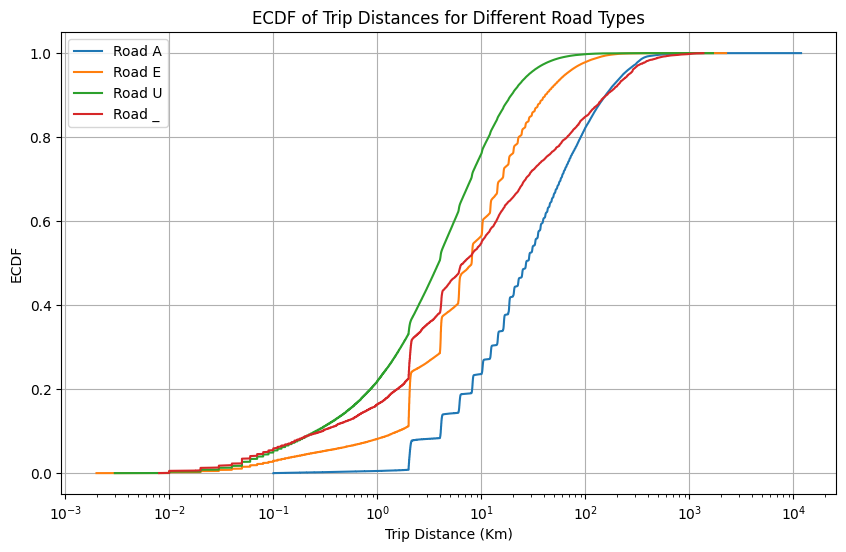

"\nFrom the ECDF plot:\n- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).\n- Road type 'U' primarily has shorter trips, with most distances under 2 km.\n- The step-like patterns in the ECDF indicate discrete trip distances.\n- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.\n"

In [3]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()


"""
From the ECDF plot:
- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).
- Road type 'U' primarily has shorter trips, with most distances under 2 km.
- The step-like patterns in the ECDF indicate discrete trip distances.
- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.
"""

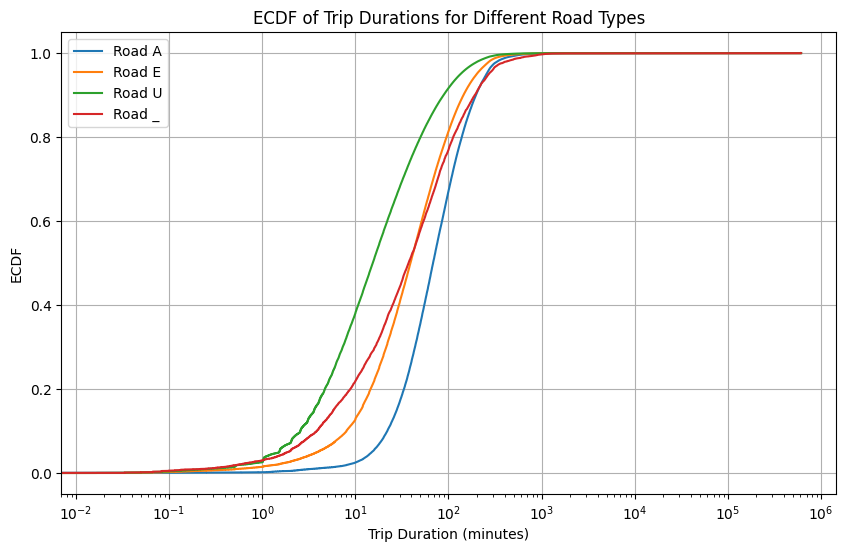

In [4]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

# Add labels, legend, and title
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

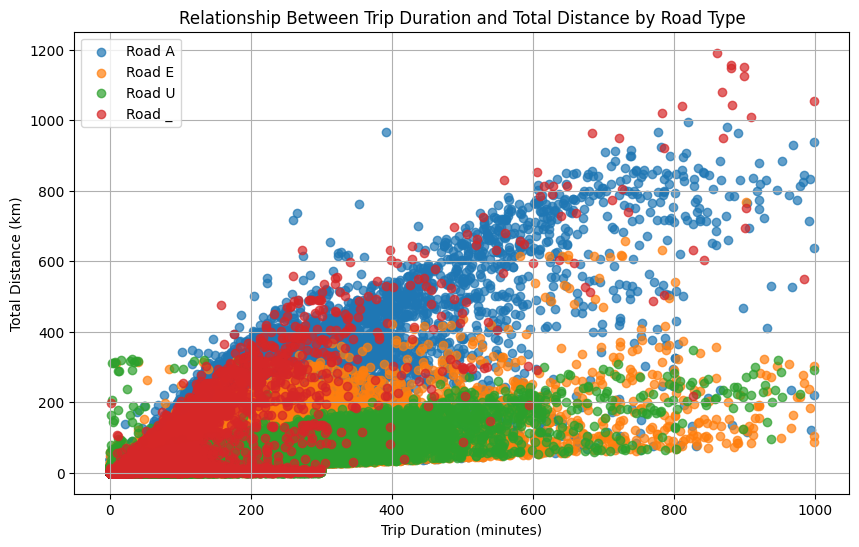

In [5]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

#data = data[data["trip_duration"] < 2880]#remove duration grate than 48 hours
data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grate than 24 hours 
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

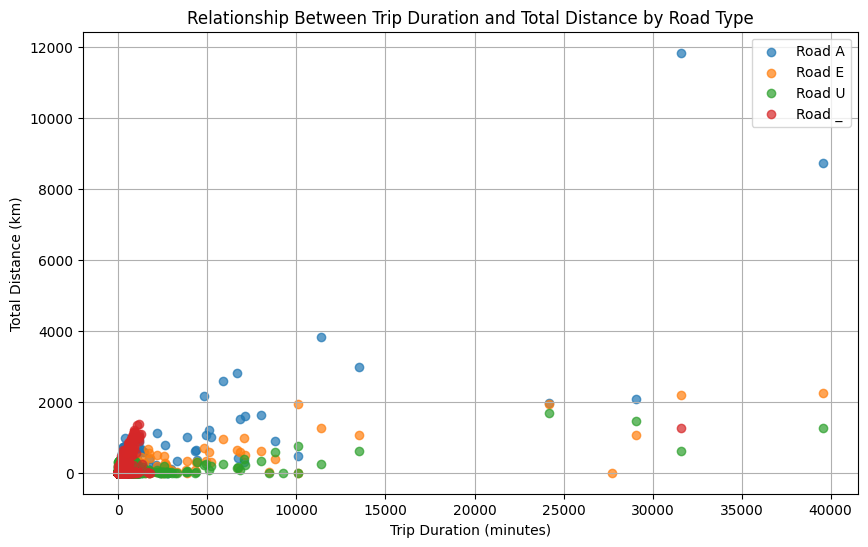

In [6]:
data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [8]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 827886


In [9]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828117

# Task 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 

data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

1243568 827889


In [3]:


data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = aggregated["total_driving_time"] / (24 * 60) * 100  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated["is_weekend"] = aggregated["day_of_week"].isin([5, 6])

workday_stats = aggregated[~aggregated["is_weekend"]].describe()
weekend_stats = aggregated[aggregated["is_weekend"]].describe()

print("Workday Statistics:")
print(workday_stats)
print("\nWeekend Statistics:")
print(weekend_stats)

Workday Statistics:
         vehicle_id  number_of_trips  total_travel_distance  \
count  41754.000000     41754.000000           41754.000000   
mean     499.000216        15.364827             394.703687   
std      288.861591        16.464647             252.380491   
min        1.000000         1.000000               0.010000   
25%      249.000000         7.000000             226.990000   
50%      498.000000        12.000000             338.090000   
75%      749.000000        19.000000             520.075000   
max     1000.000000       612.000000            2113.090000   

       total_driving_time  utilization_percentage   day_of_week  
count        41754.000000            41754.000000  41754.000000  
mean          1125.847461               78.183851      1.960387  
std            551.480354               38.297247      1.397762  
min              0.000000                0.000000      0.000000  
25%            769.291667               53.423032      1.000000  
50%           11

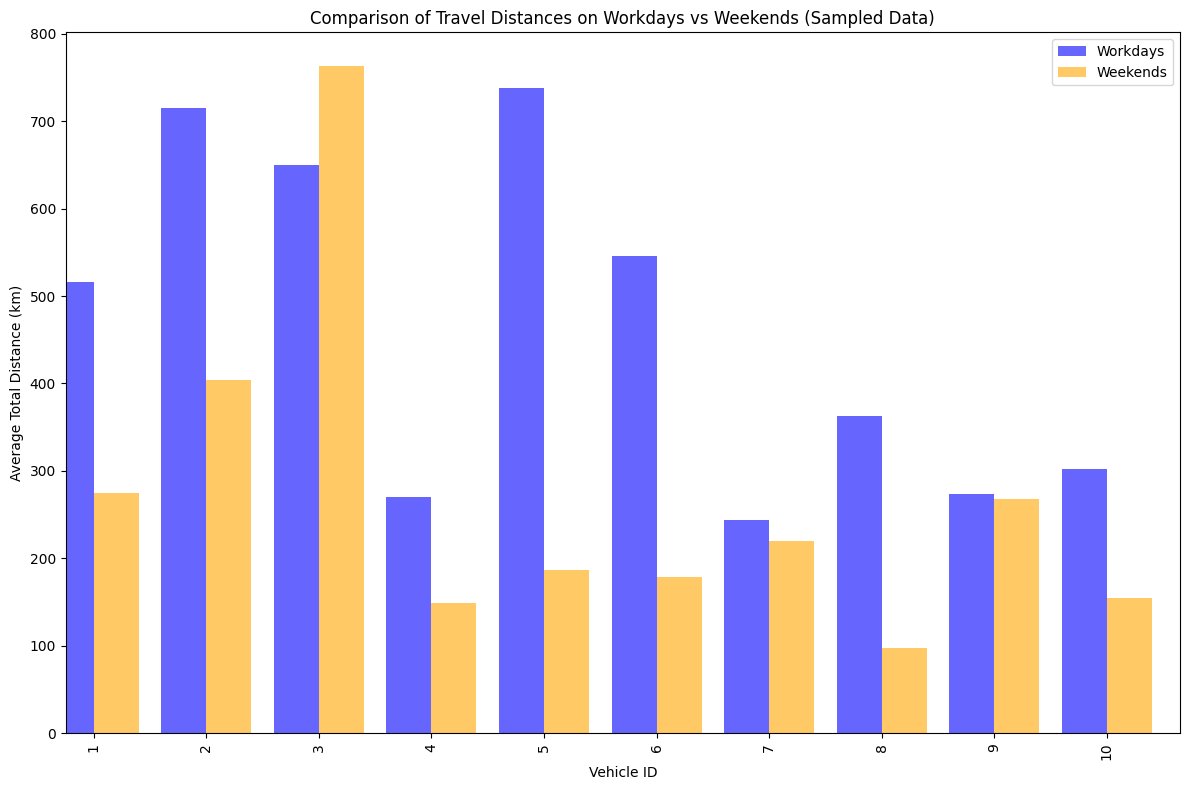

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
workday_data = aggregated[~aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = aggregated[aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = weekend_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data = workday_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data[0:10].plot(kind="bar", color="blue", alpha=0.6, position=1, width=0.4, label="Workdays", ax=ax)
weekend_data[0:10].plot(kind="bar", color="orange", alpha=0.6, position=0, width=0.4, label="Weekends", ax=ax)

ax.set_title("Comparison of Travel Distances on Workdays vs Weekends (Sampled Data)")
ax.set_ylabel("Average Total Distance (km)")
ax.set_xlabel("Vehicle ID")
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
vehicles_higher_weekdays = (workday_data > weekend_data).sum()
total_vehicles = len(workday_data)
percentage_higher_weekdays = (vehicles_higher_weekdays / total_vehicles) * 100

print(f"Percentage of vehicles with higher average distance on weekdays: {percentage_higher_weekdays:.2f}%")


Percentage of vehicles with higher average distance on weekdays: 64.96%


In [14]:
workday_data[630]

293.6388372093023

In [15]:
weekend_data[630]

192.43866666666665

# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time

In [11]:
import json

cars = {
  "cars": {
    "Tesla Model 3": {
      "cost": 40990, #EUR Germany
      "range_km": 420,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 137, #Wh/km
        "charging_time": 6
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 201,
        "total_power_kw": 208,
        "total_torque_nm": 420,
        "drive": "Rear"
      },
      "battery": {
        "nominal_capacity_kwh": 60.0,
        "useable_capacity_kwh": 57.5,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "6h15m",
          "charge_speed_kmh": 68
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 170,
          "charge_power_10_80_kw_dc": 108,
          "charge_time_min": 24,
          "charge_speed_kmh": 730
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 149,
        "highway_cold_weather_wh_km": 189,
        "combined_cold_weather_wh_km": 167,
        "city_mild_weather_wh_km": 93,
        "highway_mild_weather_wh_km": 142,
        "combined_mild_weather_wh_km": 116
      }
    },
    "BMW iX xDrive40": {
      "cost": 77300, #EUR Germany
      "range_km": 360,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 200, #Wh/km
        "charging_time": 8
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 200,
        "total_power_kw": 240,
        "total_torque_nm": 630,
        "drive": "All-Wheel Drive"
      },
      "battery": {
        "nominal_capacity_kwh": 76.6,
        "useable_capacity_kwh": 71,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "8h",
          "charge_speed_kmh": 45
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 150,
          "charge_power_10_80_kw_dc": 110,
          "charge_time_min": 31,
          "charge_speed_kmh": 580
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 180,
        "highway_cold_weather_wh_km": 220,
        "combined_cold_weather_wh_km": 200,
        "city_mild_weather_wh_km": 140,
        "highway_mild_weather_wh_km": 180,
        "combined_mild_weather_wh_km": 160
      }
    },
    "Citroen e-C3": {
      "cost": 23300, #EUR Germany
      "range_km": 260,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 150, #Wh/km
        "charging_time": 7
      },
      "performance": {
        "acceleration_0_100_kmh": "9.7 sec",
        "top_speed_kmh": 150,
        "total_power_kw": 100,
        "total_torque_nm": 260,
        "drive": "Front"
      },
      "battery": {
        "nominal_capacity_kwh": 50,
        "useable_capacity_kwh": 45,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 7.4,
          "charge_time_h": "7h",
          "charge_speed_kmh": 37
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 100,
          "charge_power_10_80_kw_dc": 75,
          "charge_time_min": 30,
          "charge_speed_kmh": 520
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 160,
        "highway_cold_weather_wh_km": 200,
        "combined_cold_weather_wh_km": 180,
        "city_mild_weather_wh_km": 120,
        "highway_mild_weather_wh_km": 160,
        "combined_mild_weather_wh_km": 140
      }
    }
  }
}



task 3

+-------------------+       +-------------------+       +-------------------+
| Define EVs & Trips| ----> | Replicate Trips   | ----> | Generate Report   |
+-------------------+       +-------------------+       +-------------------+
                               |
                               v
                        +-------------------+
                        | Simulate Consumption |
                        +-------------------+

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])

data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0
weather = "mild"
charging_type = "fast_charging" #fast_charging or home_destination
vehicle_data = data.groupby("vehicle_id")
price_fast_charging = 0.5 #EUR per kWh
price_home_charging = 0.15 #EUR per kWh
for car, specs in cars["cars"].items():
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]   #  kWh 
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id, trips in vehicle_data:
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0  
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds()/60 #minutes 
                if time_since_last_stop > 20:
                    
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60 #max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time= time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time
                    
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  #  Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))
    
    feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
    #energy_consumption_per_100km = energy_consumed_100km / total_trips if total_trips > 0 else 0
    charge_time = np.mean(total_charge_time) 
    hours, minutes = divmod(charge_time, 60)  # hours and minutes
    avg_kwh = np.mean(kwh_after_trip)
    energy_consumed_100km = np.mean(energy_consumed)/np.mean(distance_trips)*1000
    


    print(f"----------------------------------------"*3)
    print(f"Feasible trips for {car}: {feasible_percentage:.2f}%")
    #print(f"Energy consumption per 100 km for {car}: {energy_consumption_per_100km:.2f} Wh/km")
    print(f"Average charge time for {car}: {int(hours)} hours and {int(minutes)} minutes (considering only trips that needed to charge)")
    print(f"Avarage SoC after trip for {car}: {avg_kwh:.2f} kWh, Soc percentage: {avg_kwh/battery_capacity*100:.2f}%")
    print(f"Energy consumption per 100 km for {car}: {energy_consumed_100km:.2f} kWh")
    print(f"Avarage cost by buying {car} and driving {np.mean(distance_vehicles)} Km in 2 months: \n-energy: {np.mean(energy_vehicles)*price_home_charging:.2f} EUR \n-car: {specs['cost']:.2f} EUR")
            

------------------------------------------------------------------------------------------------------------------------
Feasible trips for Tesla Model 3: 95.50%
Average charge time for Tesla Model 3: 0 hours and 14 minutes (considering only trips that needed to charge)
Avarage SoC after trip for Tesla Model 3: 45.85 kWh, Soc percentage: 79.74%
Energy consumption per 100 km for Tesla Model 3: 119.02 kWh
Avarage cost by buying Tesla Model 3 and driving 18670.90402102102 in 2 months: 
energy: 333.33 EUR 
 car: 40990.00 EUR
------------------------------------------------------------------------------------------------------------------------
Feasible trips for BMW iX xDrive40: 94.44%
Average charge time for BMW iX xDrive40: 0 hours and 19 minutes (considering only trips that needed to charge)
Avarage SoC after trip for BMW iX xDrive40: 55.18 kWh, Soc percentage: 77.71%
Energy consumption per 100 km for BMW iX xDrive40: 161.50 kWh
Avarage cost by buying BMW iX xDrive40 and driving 18382.7